## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df_sample = df.sample(frac = 0.5, random_state = 42)
df_sample.head()

,id,qid1,qid2,question1,question2,is_duplicate
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1


In [4]:
# balanced sample
#df_balanced_sample = df.sample(frac = 0.1, random_state = 42, weights='is_duplicate')

In [5]:
df_sample.shape

(202145, 6)

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [6]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202145 entries, 8067 to 372076
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            202145 non-null  int64 
 1   qid1          202145 non-null  int64 
 2   qid2          202145 non-null  int64 
 3   question1     202145 non-null  object
 4   question2     202144 non-null  object
 5   is_duplicate  202145 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 10.8+ MB


In [7]:
df_sample.dropna(inplace=True)

In [8]:
df_sample['is_duplicate'].value_counts()

0    127297
1     74847
Name: is_duplicate, dtype: int64

In [9]:
# Are we missing any data?
print('Number of nulls in label: {}'.format(df_sample['is_duplicate'].isnull().sum()))
print('Number of nulls in q1: {}'.format(df_sample['question1'].isnull().sum()))
print('Number of nulls in q2: {}'.format(df_sample['question2'].isnull().sum()))

Number of nulls in label: 0
Number of nulls in q1: 0
Number of nulls in q2: 0


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [10]:
# Drop columns
df_sample = df_sample[['question1', 'question2', 'is_duplicate']]

In [11]:
df_sample['question_merged'] = df_sample['question1'] + ' ' + df_sample['question2']

In [12]:
df_sample.head()

,question1,question2,is_duplicate,question_merged
8067,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,How do I play Pokémon GO in Korea? How do I pl...
368101,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,What are some of the best side dishes for crab...
70497,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,Which is more advisable and better material fo...
226567,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,How do I improve logical programming skills? H...
73186,How close we are to see 3rd world war?,How close is a World War III?,1,How close we are to see 3rd world war? How clo...


In [13]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202144 entries, 8067 to 372076
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   question1        202144 non-null  object
 1   question2        202144 non-null  object
 2   is_duplicate     202144 non-null  int64 
 3   question_merged  202144 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.7+ MB


In [14]:
# remove punctuation
import string

def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text

df_sample['question_merged'] = df_sample['question_merged'].apply(lambda x: remove_punct(x))

In [15]:
# Import the NLTK package and download the necessary data
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

ENGstopwords = stopwords.words('english')

In [16]:
# stopword, tokenize and tf-idf
input_ = df_sample['question_merged']
vectorizer = TfidfVectorizer(strip_accents = 'ascii', lowercase = True, stop_words = 'english')
X = vectorizer.fit_transform(input_)

Words to Vec Prep

In [17]:
# tokenize
import re

def tokenize(text):
    tokens = text.split()
    return tokens

df_sample['q12_token'] = df_sample['question_merged'].apply(lambda x: tokenize(x.lower()))


In [18]:
# drop stopwords
def remove_stopwords(tokenized_text):    
    text = [word for word in tokenized_text if word not in ENGstopwords]
    return text

df_sample['q12_token_stop'] = df_sample['q12_token'].apply(lambda x: remove_stopwords(x))

## Stemming

In [19]:
from nltk.stem.snowball import SnowballStemmer

In [20]:
stemmer = SnowballStemmer("english")

In [21]:
def stemming(array):
    return [stemmer.stem(token) for token in array]

df_sample['stemmed'] = df_sample['q12_token_stop'].apply(stemming)


In [22]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202144 entries, 8067 to 372076
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   question1        202144 non-null  object
 1   question2        202144 non-null  object
 2   is_duplicate     202144 non-null  int64 
 3   question_merged  202144 non-null  object
 4   q12_token        202144 non-null  object
 5   q12_token_stop   202144 non-null  object
 6   stemmed          202144 non-null  object
dtypes: int64(1), object(6)
memory usage: 12.3+ MB


In [23]:
input_stem = df_sample['stemmed'].apply(lambda x: " ".join(x) )
input_stem

8067            play pokémon go korea play pokémon go china
368101    best side dish crab cake good side dish buffal...
70497     advis better materi crash test automobil ducti...
226567    improv logic program skill improv logic skill ...
73186           close see 3rd world war close world war iii
                                ...                        
108218    way gain follow facebook would gain follow fac...
390486           delet line account delet imagekind account
346488    what funniest highbrow joke youv ever heard be...
179107    maharashtrian blend south india north india ma...
372076    safest combat posit us militari would dutch pe...
Name: stemmed, Length: 202144, dtype: object

In [24]:
vectorizer_stem = TfidfVectorizer()
X_stem = vectorizer_stem.fit_transform(input_stem)

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

Questions:
    - should the 2 questions columsn be merged so that when we do tf-idf we can see a count of the duplicate words within the list and the words that are not duplicates?
    - for words to vec, once it is set up do i just pass that into another model to see if it will work?
    - does this need to be completed as a neural network?
    - 

In [25]:
#Merge question columns

In [26]:
#Remove duplicates

In [27]:
#tf-idf

In [28]:
#word2vec
import gensim

Model_SG = gensim.models.Word2Vec(df_sample['q12_token_stop'], vector_size = 100, window = 3, min_count = 2, sg = 1)
#Model_SG_stemmed = gensim.models.Word2Vec(df_sample['stemmed'], vector_size = 100, window = 3, min_count = 2, sg = 1)
#Model_CBoW = gensim.models.Word2Vec(df_sample['q12_token_stop'], vector_size = 100, window = 5, min_count = 1)
#Model_CBoW = gensim.models.Word2Vec(df_sample['stemmed'], vector_size = 100, window = 5, min_count = 1)

In [29]:
# what I want to do is calculate the cosine similarity for the 2 sentences based on the w2v model.
# the generated models above will be shite so need to load back in the google news model and use that.

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [30]:
y = df_sample['is_duplicate']

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Initialize different Classification Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier



F1 score: 0.6985216099596803
Accuracy score: 0.7891612456405056


<AxesSubplot:>

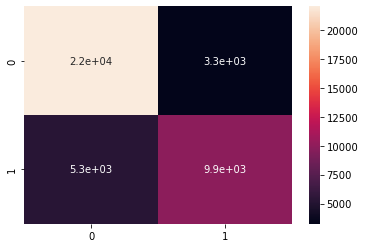

In [33]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

cl1 = RandomForestClassifier(random_state=42)
cl1.fit(X_train,y_train)
z = cl1.predict(X_test)
accuracy = accuracy_score(y_test, z)
f1 = f1_score(y_test,z)
C = confusion_matrix(y_test,z)
print(f'F1 score: {f1}')
print(f'Accuracy score: {accuracy}')
sns.heatmap(C, annot=True)

In [ ]:
cl2 = SVC(probability=True, random_state=42)
cl2.fit(X_train,y_train)
z = cl2.predict(X_test)
accuracy = accuracy_score(y_test, z)
f1 = f1_score(y_test,z)
C = confusion_matrix(y_test,z)
print(f'F1 score: {f1}')
print(f'Accuracy score: {accuracy}')
sns.heatmap(C, annot=True)

In [ ]:
#cl3 = LogisticRegression(random_state=42)
#cl3.fit(X_train,y_train)
#z = cl3.predict(X_test)
#accuracy = accuracy_score(y_test, z)
#f1 = f1_score(y_test,z)
#C = confusion_matrix(y_test,z)
#print(f'F1 score: {f1}')
#print(f'Accuracy score: {accuracy}')
#sns.heatmap(C, annot=True)

In [ ]:
#cl4 = GradientBoostingClassifier(random_state=42)
#cl4.fit(X_train,y_train)
#z = cl4.predict(X_test)
#accuracy = accuracy_score(y_test, z)
#f1 = f1_score(y_test,z)
#C = confusion_matrix(y_test,z)
#print(f'F1 score: {f1}')
#print(f'Accuracy score: {accuracy}')
#sns.heatmap(C, annot=True)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_stem, y, test_size=0.2, random_state=42)

In [ ]:
cl2 = SVC(probability=True, random_state=42)
cl2.fit(X_train,y_train)
z = cl2.predict(X_test)
accuracy = accuracy_score(y_test, z)
f1 = f1_score(y_test,z)
C = confusion_matrix(y_test,z)
print(f'F1 score: {f1}')
print(f'Accuracy score: {accuracy}')
sns.heatmap(C, annot=True)

cl1 = RandomForestClassifier(random_state=42)
cl2 = SVC(probability=True, random_state=42)
cl3 = KNeighborsClassifier()
cl4 = LogisticRegression(random_state=42)
cl5 = GradientBoostingClassifier(random_state=42)
ft1 = PCA()
ft2 = SelectKBest()

# Initiaze the hyperparameters for each dictionary

param1 = {}
#param1['classifier__n_estimators'] = [2, 5, 10, 15, 50]
#param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier'] = [cl1]

param2 = {}
param2['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
#param2['classifier__kernal'] = ['rbf', 'linear']
param2['classifier'] = [cl2]

param3 = {}
#param3['classifier__n_neighbors'] = [2,5,10,25,50]
param3['classifier'] = [cl3]

param4 = {}
param4['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param4['classifier__penalty'] = ['l1', 'l2']
param4['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param4['classifier__max_iter'] = [250]
param4['classifier'] = [cl4]

param5 = {}
#param5['classifier__n_estimators'] = [2, 5, 10, 50, 100, 250]
#param5['classifier__max_depth'] = [5, 10, 20]
param5['classifier'] = [cl5]

param6 = {}
param6['features__pca__n_components'] = [2, 5, 8, 11, 14, 17]
param6['features'] = [ft1]

param7 = {}
param7['features__select_best__k'] = [1, 3, 6]
param7['features'] = [ft2]

#no feature union
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

classifiers = [cl1, cl2, cl3]

#params = [param1, param2, param3, param5]
params = [param1, param2, param3, param5]

#feature_union = FeatureUnion([('pca', PCA()),
                              #('select_best', SelectKBest())])

pipeline = Pipeline(steps = [('classifier', 'passthrough')])

grid = GridSearchCV(pipeline, param_grid = params, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
best_hyperparams = grid.best_params_
best_acc = grid.score(X_test, y_test)
print(f'Best test set accuracy:\n\t {best_acc}\nAchieved with hyperparameters:\n\t {best_hyperparams}')